<a href="https://colab.research.google.com/github/Ceejay16042/CatVdog-classifier-using-CNN/blob/main/catVdogs_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from shutil import copyfile
from tensorflow.keras import utils
from tensorflow.keras import Model
from tensorflow.keras import optimizers, losses
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator


### Applying Transfer learning

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-16 19:41:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   162MB/s    in 0.5s    

2023-09-16 19:41:14 (162 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers so.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze/lock the weights of the layers to make them untrainable.
for layer in pre_trained_model.layers:
  layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [ ]:
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print("THE number of parameters in the pretrained model is", pre_trained_model.count_params())

last layer output shape:  (None, 7, 7, 768)
THE number of parameters in the pretrained model is 21802784


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Fetching the local CatVdog dataset to be trained on




In [ ]:
#downloading a fraction of the dataset(2000 images) from kaggle
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"


--2023-09-16 19:41:20--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 96.6.96.63, 2600:1409:9800:98c::317f, 2600:1409:9800:984::317f
Connecting to download.microsoft.com (download.microsoft.com)|96.6.96.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  61.8MB/s    in 13s     

2023-09-16 19:41:33 (60.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
#Extracting the cat vs dogs zipfile to be used
def file_extract(local_file, path):
  extracted = True
  if extracted:
    extracted_file = zipfile.ZipFile(local_file, 'r')
    file_path = extracted_file.extractall(path)
    print(f"Zipfile has been successfully extracted into path {path}")
  else:
    print("Error during extraction")

In [ ]:
file_extract("/tmp/cats-and-dogs.zip", '/content')

Zipfile has been successfully extracted into path /content


In [ ]:
#Checking for the number of images in the cats and dogs directory

source_path_cats = os.path.join('/content/PetImages', 'Cat/')
source_path_dogs = os.path.join('//content/PetImages', 'Dog/')


print('The length of the source_path_cats is {}'.format(len(os.listdir(source_path_cats))))
print('The length of the source_dog_dogs is {}'.format(len(os.listdir(source_path_dogs))))


The length of the source_path_cats is 12501
The length of the source_dog_dogs is 12501


In [ ]:
# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /content/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

In [ ]:
source_path = '/content/catvDogs/'

#checking if directory exists, and removing to prevent duplicates
if os.path.exists(source_path):
  shutil.rmtree(source_path)


#Creating new training and validation subdirectories to further classify the images
def create_subdirectories(root_path):

  #subdirectories to be created
  os.makedirs(os.path.join(source_path, 'training/'))
  os.makedirs(os.path.join(f'{source_path}/training', 'cats/'))
  os.makedirs(os.path.join(f'{source_path}/training', 'dogs/'))
  os.makedirs(os.path.join(source_path, 'validation/'))
  os.makedirs(os.path.join(f'{source_path}/validation', 'cats/'))
  os.makedirs(os.path.join(f'{source_path}/validation', 'dogs/'))

try:
  create_subdirectories(root_path=source_path)
except FileExistsError:
  (f'The file {root_path} already exists!! duplicates not allowed')

In [ ]:
#Checking if the subdirectories function worked properly and listing filepaths to the newly created directories
for rootdir, dirs, files in os.walk(source_path):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/catvDogs/training
/content/catvDogs/validation
/content/catvDogs/training/cats
/content/catvDogs/training/dogs
/content/catvDogs/validation/cats
/content/catvDogs/validation/dogs


In [ ]:
# #splitting the images into the training and testing subdirectories in the ratio 90:10
def train_test_split(rootpath, training_dir, validation_dir, split_size):

#using the sample method in the random module to randomize the shuffling of the images into the train and validation dir
  shuffled_files = random.sample(os.listdir(rootpath), len(os.listdir(rootpath)))

  # Finds total number of files in training dir
  training_number = int(len(shuffled_files) * split_size)

  i = 0
  target = training_dir

  for item in shuffled_files:
    item_source = os.path.join(rootpath, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      shutil.copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING once i hits the train_size 90%,
    if i == training_number:
      target = validation_dir

# os.
pass

### END CODE HERE


In [ ]:
# /content/PetImages/Cat
root_path_cat = "/content/PetImages/Cat"
root_path_dog = '/content/PetImages/Dog'

training_path_dir = '/content/catvDogs/training'
validation_path_dir = '/content/catvDogs/validation/'

#Path to training images
cat_training_path = os.path.join(training_path_dir, 'cats/')
dogs_training_path = os.path.join(training_path_dir, 'dogs/')

#Path to validation images
cat_validation_path = os.path.join(validation_path_dir, 'cats/')
dogs_validation_path = os.path.join(validation_path_dir, 'dogs/')

  #Empties the directory to avoid the repetition of image-files in the directory
try:

  if len(os.listdir(cat_training_path)) > 0:
    for file in os.scandir(cat_training_path):
      os.remove(file.path)
  if len(os.listdir(dogs_training_path)) > 0:
    for file in os.scandir(dogs_training_path):
      os.remove(file.path)
  if len(os.listdir(cat_validation_path)) > 0:
    for file in os.scandir(cat_validation_path):
      os.remove(file.path)
  if len(os.listdir(dogs_validation_path)) > 0:
    for file in os.scandir(dogs_validation_path):
      os.remove(file.path)

  #running the train_test_split function
  train_test_split(rootpath=root_path_cat, training_dir=cat_training_path, validation_dir=cat_validation_path, split_size=.9)

  train_test_split(rootpath=root_path_dog, training_dir=dogs_training_path,  validation_dir=dogs_validation_path, split_size=.9)


  time.sleep(5)


  print('The length of files in the cat_training_dir is', len(os.listdir(cat_training_path)))
  print('The length of files in the dog_training_dir is', len(os.listdir(dogs_training_path)))
  print('The length of files in the cat_validation_dir is', len(os.listdir(cat_validation_path)))
  print('The length of files in the dog_validation_dir is', len(os.listdir(dogs_validation_path)))
except FileExistsError:
  (f'The file {rootpath} already exists!! duplicates not allowed')


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.
The length of files in the cat_training_dir is 11250
The length of files in the dog_training_dir is 11250
The length of files in the cat_validation_dir is 1249
The length of files in the dog_validation_dir is 1249


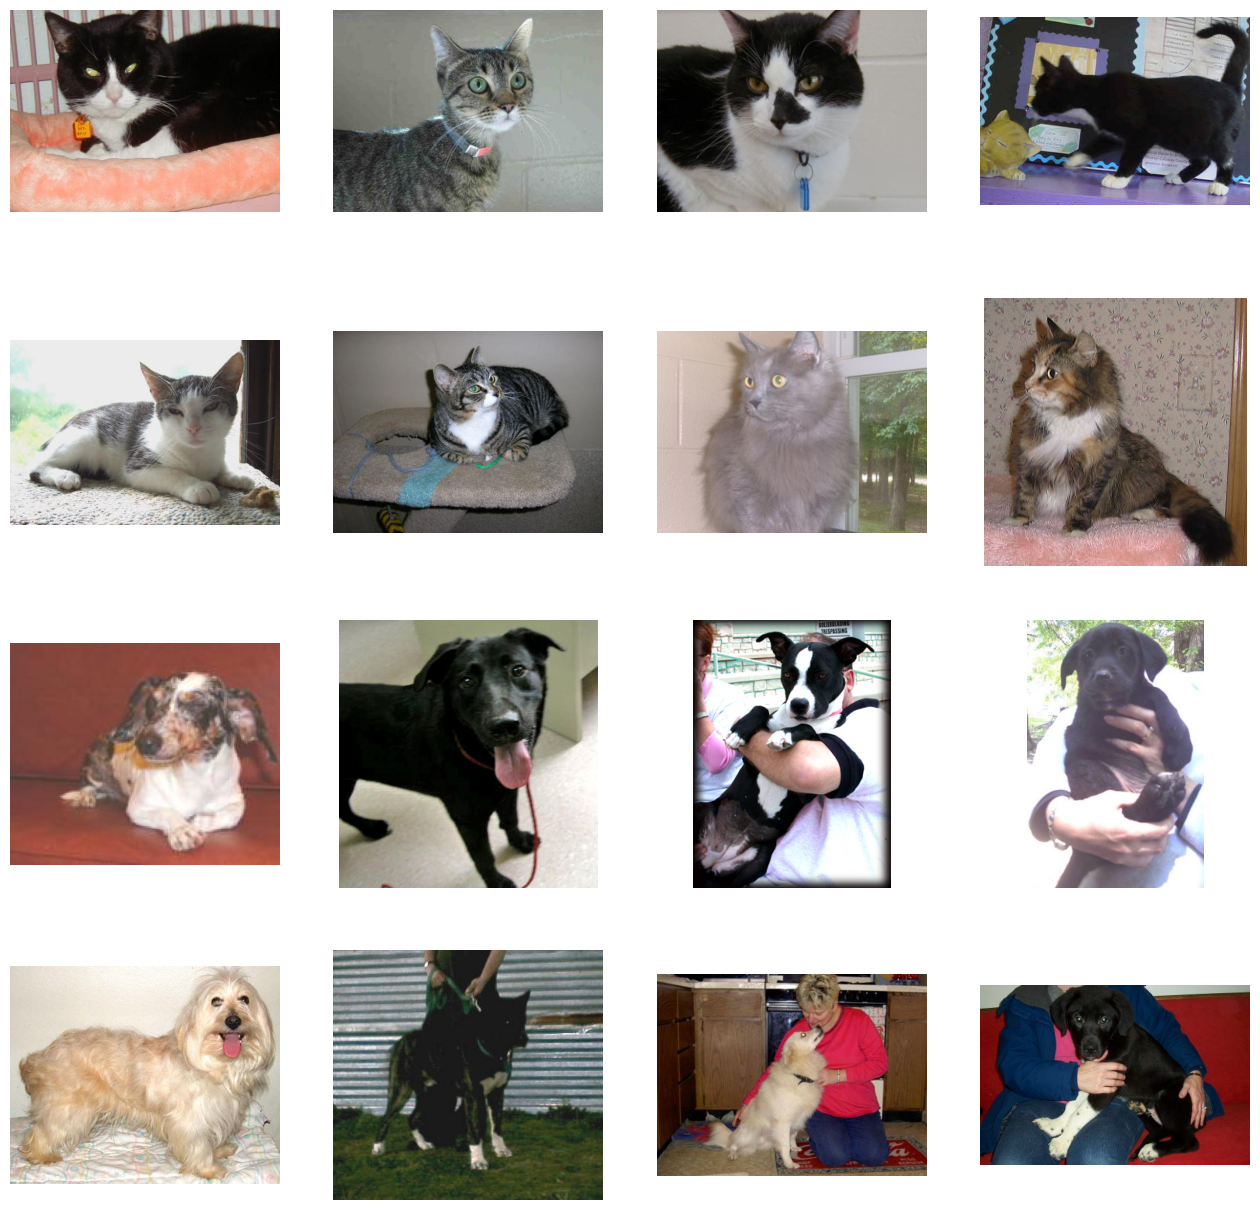

In [ ]:
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


cat_train_dir = os.listdir(cat_training_path)
dogs_train_dir = os.listdir(dogs_training_path)

#displays the cat and images in the range(0, 8)
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(cat_training_path, fname)
                for fname in cat_train_dir[pic_index-8:pic_index]]
next_dogs_pix = [os.path.join(dogs_training_path, fname)
                for fname in dogs_train_dir[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dogs_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
#getting the pixel size of the images
image_dimension = tf.keras.utils.load_img(os.path.join(cat_training_path, os.listdir(cat_training_path)[2]))
image_dimension = tf.keras.utils.img_to_array(image_dimension)
print("the shape of the images are in the dimension", image_dimension.shape)

#maximum pixel size which determines the rescaling
print(f"The maximum pixel value used is: {np.max(image_dimension)}")


the shape of the images are in the dimension (375, 500, 3)
The maximum pixel value used is: 215.0


In [ ]:
#Data Augmentation and scaling
def train_val_generators(training_dir, validation_dir):

  #Instatiating the ImageDataGenerator to rescale the images for improved model performance
  train_datagen = ImageDataGenerator(rescale= 1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range=0.2,
                                     horizontal_flip = False
                                     )

  train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                    batch_size = 10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale= 1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                    batch_size = 10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(training_path_dir, validation_path_dir)

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer= RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# training your model on catVdog dataset using the knowledge obtained from the transferlearning
history = model.fit(train_generator,
          steps_per_epoch=100,
          epochs=10,
          validation_steps=50,
          validation_data=validation_generator)

Epoch 1/10
100/100 [==============================] - 79s 764ms/step - loss: 0.3428 - acc: 0.8590 - val_loss: 0.1515 - val_acc: 0.9420
Epoch 2/10
100/100 [==============================] - 75s 755ms/step - loss: 0.2300 - acc: 0.9100 - val_loss: 0.0976 - val_acc: 0.9640
Epoch 3/10
100/100 [==============================] - 75s 752ms/step - loss: 0.2731 - acc: 0.8910 - val_loss: 0.1624 - val_acc: 0.9540
Epoch 4/10
100/100 [==============================] - 75s 753ms/step - loss: 0.2225 - acc: 0.9190 - val_loss: 0.0750 - val_acc: 0.9620
Epoch 5/10
100/100 [==============================] - 76s 762ms/step - loss: 0.2444 - acc: 0.9030 - val_loss: 0.1309 - val_acc: 0.9540
Epoch 6/10
100/100 [==============================] - 75s 756ms/step - loss: 0.2354 - acc: 0.9210 - val_loss: 0.1041 - val_acc: 0.9560
Epoch 7/10
100/100 [==============================] - 82s 810ms/step - loss: 0.1967 - acc: 0.9230 - val_loss: 0.1370 - val_acc: 0.9440
Epoch 8/10
100/100 [==============================] - 8

In [ ]:
def check_model_performance(train_acc, train_loss, val_acc, val_loss):
  training_acc = history.history[train_acc]
  training_loss = history.history[train_loss]
  validation_acc = history.history[val_acc]
  validation_loss = history.history[val_loss]

  return training_acc, training_loss, validation_acc, validation_loss


In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
train_acc, train_loss, val_acc, val_loss = check_model_performance('acc', 'loss', 'val_acc', 'val_loss')
print("The training accuracy of the model is", round(train_acc[-1], 2))
print("The validation accuracy of the model is ", round(val_acc[-1], 2))

The training accuracy of the model is 0.91
The validation accuracy of the model is  0.96


<Figure size 640x480 with 0 Axes>

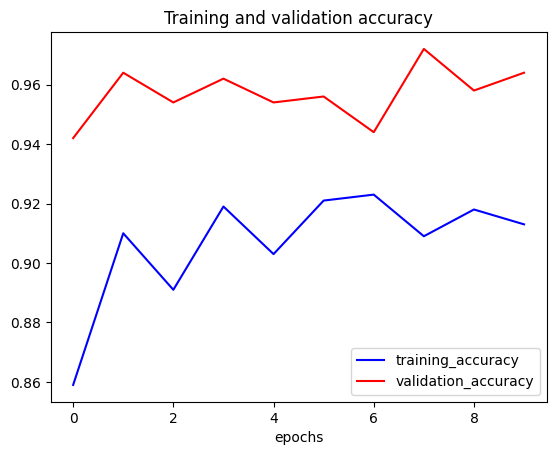

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(train_acc))
# print(epochs)

plt.title("Training and validation accuracy")
plt.plot(epochs, train_acc, 'b', label='training_accuracy')
plt.plot(epochs, val_acc, "r", label="validation_accuracy")
plt.xlabel('epochs')
plt.legend(loc=0)
plt.figure()


> Note: From the line plot above, it is evident that the training and validation accuracy follow a similar pattern, suggesting the absence of overfitting in the model. This outcome can be attributed to the incorporation of data augmentation and dropout techniques

Saving 10 of the Best Ways To Eliminate Litter Box Odors That May Surprise You!.jfif to 10 of the Best Ways To Eliminate Litter Box Odors That May Surprise You! (6).jfif
Saving download (1).jfif to download (1) (18).jfif
Saving How To Know Your Cat Feelings Just By Looking.jfif to How To Know Your Cat Feelings Just By Looking (10).jfif
Saving photo-1598875706250-21faaf804361.jfif to photo-1598875706250-21faaf804361 (6).jfif
1/1 [==============================] - 0s 74ms/step


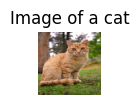

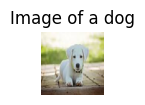

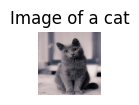

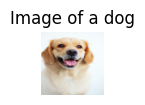

In [ ]:
#Testing the model with different images to evaluate performance
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images

  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  # print(classes[0])

  fig = plt.figure(figsize=(3, 2))

  if classes[0]>0.5:
    fig.add_subplot(2, 1, 1)
    # print(fn + " " + '\n' + "Image of a Dog")
    plt.tight_layout()
    plt.axis('off')
    plt.title('Image of a dog')
    plt.imshow(img)
  else:
    fig.add_subplot(2, 2, 2)
    plt.tight_layout()
    # print(fn + " " + '\n' "Image of a Cat")
    plt.axis('off')
    plt.title('Image of a cat')
    plt.imshow(img)

In [ ]:
#saving the model
import pickle
def save_model(filename):
  with open(filename, 'wb') as f:
    pickle.dump(history.history, f)

  files.download(filename)


save_model('Cat&Dog_Classifier_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>